# Supervised ML Algorithms

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(
    X: np.ndarray, y: np.ndarray, classifier: Any, resolution: float = 0.02
) -> None:
    """
    Plot decision regions for a classifier.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Input features.
    y : np.ndarray of shape (n_samples,)
        Target labels.
    classifier : Any
        Trained classifier object with a predict method.
    resolution : float, optional, default=0.02
        Step size for the contours.

    Returns
    -------
    None
    """
    # Setup marker generator and color map
    markers: tuple[str, ...] = ("o", "s", "^", "v", "<")
    colors: tuple[str, ...] = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap: ListedColormap = ListedColormap(colors[: len(np.unique(y))])

    x1_min: float = X[:, 0].min() - 1
    x1_max: float = X[:, 0].max() + 1
    x2_min: float = X[:, 1].min() - 1
    x2_max: float = X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )

    lab: np.ndarray = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolor="black",
        )

In [4]:
fp: str = "./data/iris_data.csv"
df: pl.DataFrame = pl.read_csv(fp)
df = df.filter(pl.col("class").ne("None"))

df.head()

sepal_length,sepal_width,petal_length,petal_width,class
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""Iris-setosa"""
4.9,3.0,1.4,0.2,"""Iris-setosa"""
4.7,3.2,1.3,0.2,"""Iris-setosa"""
4.6,3.1,1.5,0.2,"""Iris-setosa"""
5.0,3.6,1.4,0.2,"""Iris-setosa"""


In [5]:
df.select("class").to_series().value_counts().to_pandas()

,class,count
0,Iris-versicolor,50
1,Iris-setosa,50
2,Iris-virginica,50


In [6]:
X: np.ndarray = df.select(
    # ["sepal_length", "sepal_width", "petal_length", "petal_width"]
    ["sepal_length", "petal_length"]
).to_numpy()

y: np.ndarray = (
    df.with_columns(
        label=pl.when(pl.col("class").eq("Iris-setosa"))
        .then(pl.lit(0))
        .otherwise(pl.lit(1))
    )
    .select("label")
    .to_numpy()
    .squeeze()
)

X.shape, y.shape

((150, 2), (150,))

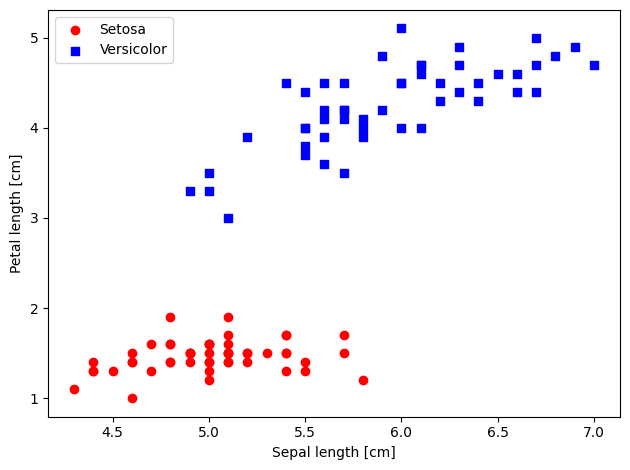

In [7]:
# plot data
plt.scatter(X[:50, 0], X[:50, 1], color="red", marker="o", label="Setosa")
plt.scatter(X[50:100, 0], X[50:100, 1], color="blue", marker="s", label="Versicolor")
plt.xlabel("Sepal length [cm]")
plt.ylabel("Petal length [cm]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [8]:
X_std: np.ndarray = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
X_std.shape

(150, 2)

### Logistic Regression [Implementation]

- Adaline and logistic regression differ primarily in their activation functions.
- Adaline uses `identity` function, while logistic regression uses sigmoid function.

<br>

<img src="./images/logistic reg 2024-07-15 at 10.35.54 PM.png" width="600">

[image source](https://subscription.packtpub.com/book/data/9781801819312/3/ch03lvl1sec16/modeling-class-probabilities-via-logistic-regression)


#### Logistic Regression Loss Function

$$ L(w,b) = \frac{1}{n}\sum_{i=1}^{n}[-y^{(i)}\log(\sigma(z^{(i)})) - (1-y^{(i)})\log(1-\sigma(z^{(i)}))] $$


#### Training: Fit
$$z = (X^Tw + b)$$
$$\hat{y} = \sigma(z)$$

- Update in weights and bias is obtained by multiply -ve gradient with learning rate.

eq (1)
$$ \Delta{w} = -\eta * (\Delta_{w}  L(w,b)) $$
$$ \Delta{w} = -\eta * (-\frac{2}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})x_{j}^{(i)}) $$  

eq (2)
$$ \Delta{b} = -\eta * (\Delta_{b}  L(w,b)) $$
$$ \Delta{b} = -\eta * (-\frac{2}{n} \sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})) $$

#### Update weights and bias

$$ w = w + \Delta{w} $$
$$ b = b + \Delta{b} $$

Where:

$ \sigma(z) $ is a `sigma` activation function.

In [9]:
class LogisticRegressionGD:
    """
    Logistic Regression Classifier using Gradient Descent.

    Parameters
    ----------
    eta : float, default=0.05
        Learning rate (between 0.0 and 1.0).
    epochs : int, default=10
        Number of passes over the training dataset.
    seed : int, default=42
        Random number generator seed for random weight initialization.
    """

    def __init__(self, eta=0.05, epochs: int = 10, seed: int = 42):
        """
        Initialize the LogisticRegressionGD instance.

        Parameters
        ----------
        eta : float, optional
            Learning rate (between 0.0 and 1.0).
        epochs : int, optional
            Number of passes over the training dataset.
        seed : int, optional
            Random number generator seed for random weight initialization.
        """
        assert 0 <= eta <= 1, "eta must be between 0 and 1"
        assert epochs >= 1, "epochs must be greater than 0"
        assert seed >= 0, "seed must be greater than or equal to 0"
        self.eta = eta
        self.epochs = epochs
        self.seed = seed

    def __repr__(self) -> str:
        """
        Return a string representation of the LogisticRegressionGD instance.

        Returns
        -------
        str
            String representation of the instance.
        """
        return (
            f"{self.__class__.__name__}(eta={self.eta}, "
            f"epochs={self.epochs}, seed={self.seed})"
        )

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LogisticRegressionGD":
        """
        Fit the model to the training data.

        Parameters
        ----------
        X : np.ndarray
            Training data, shape: (n_samples, n_features).
        y : np.ndarray
            Target values, shape: (n_samples,).

        Returns
        -------
        self : LogisticRegressionGD
            Fitted estimator.
        """
        n_samples: int
        n_features: int
        n_samples, n_features = X.shape
        rng = np.random.default_rng(self.seed)
        # Size: (n_features,)
        self.w_: np.ndarray = rng.normal(loc=0.0, scale=0.01, size=(n_features,))
        self.b_: float = 0.0  # Scaler
        self.losses_: list[float] = []

        for _ in range(self.epochs):
            # Size: (1, n_samples)
            output: np.ndarray = self._activation(self._predict(X))
            # y: (1, n_samples); error: (1, n_samples)
            error: np.ndarray = y - output

            # error * X: (1, n_samples) * (n_samples, n_features) -> (1, n_features)
            dw: np.ndarray = -self.eta * ((-2 * np.dot(error, X)) / n_samples)
            db: float = -self.eta * ((-2 * np.sum(error)) / n_samples)
            self.w_ += dw
            self.b_ += db

            loss: np.ndarray = (
                (np.dot(-y, np.log(output))) - np.dot((1 - y), np.log(1 - output))
            ) / n_samples
            self.losses_.append(loss)

        return self

    def _predict(self, X: np.ndarray) -> np.ndarray:
        """
        Compute net input.

        Parameters
        ----------
        X : np.ndarray
            Input data, shape: (n_samples, n_features).

        Returns
        -------
        np.ndarray
            Net input, shape: (1, n_samples).
        """
        # w_: (n_features,); X: (n_samples, n_features)
        # z: w_ * X.T -> (1, n_features) * (n_features, n_samples) -> (1, n_samples)
        z: np.ndarray = np.dot(self.w_, X.T) + self.b_
        return z

    def _activation(self, z: np.ndarray) -> np.ndarray:
        """
        Compute logistic sigmoid activation.

        Parameters
        ----------
        z : np.ndarray
            Net input, shape: (1, n_samples).

        Returns
        -------
        np.ndarray
            Output of the logistic sigmoid activation function, shape: (1, n_samples).
        """
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Return class label after unit step.

        Parameters
        ----------
        X : np.ndarray
            Input data, shape: (n_samples, n_features).

        Returns
        -------
        np.ndarray
            Predicted class labels, shape: (n_samples,).
        """
        return np.where(self._activation(self._predict(X)) >= 0.5, 1, 0)

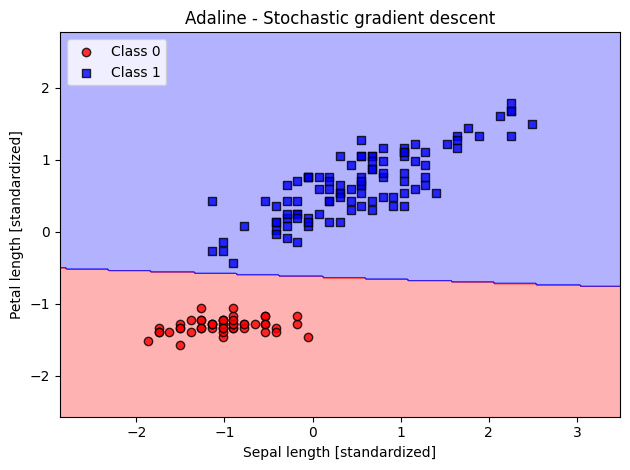

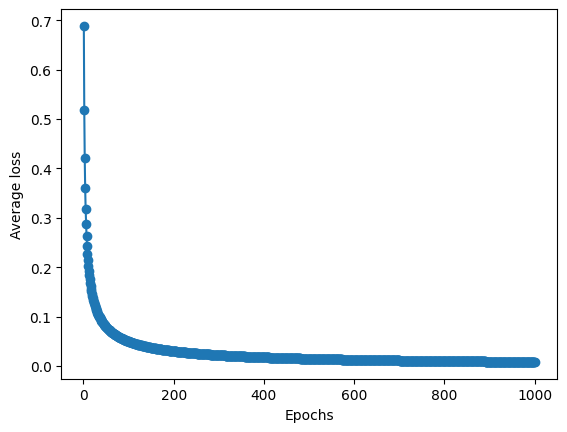

In [10]:
log_gd: LogisticRegressionGD = LogisticRegressionGD(eta=3e-1, epochs=1_000, seed=1)
log_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=log_gd)
plt.title("Adaline - Stochastic gradient descent")
plt.xlabel("Sepal length [standardized]")
plt.ylabel("Petal length [standardized]")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

plt.plot(range(1, len(log_gd.losses_) + 1), log_gd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average loss")

plt.show()